# Step 2: classify.ipynb
* Made by Vivian Tao
* Last update by Vivian Tao (June 16, 2025)

This file imports a classifier model and predicts whether bacteria trajectories are swimming or diffusive.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pims
import trackpy as tp
from scipy.optimize import curve_fit
import seaborn as sns
import joblib

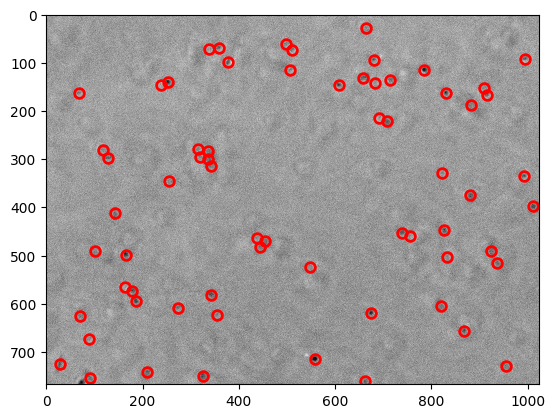

66


<Figure size 640x480 with 0 Axes>

In [ ]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]

# for files with RGB
#frames = gray(pims.open("data2/day4_background/*.tif*"))

# for other files
frames = pims.open("../../ambdata/day2_background/*.tif*")

upp = 0.25 # upp is microns per pixel
fps = 10 # fps is frames per second

BACT_SIZE = 13 # must be an odd integer, better to be on the larger end
MIN_MASS = 100000
sub_drift = True

# Load the classifier model made from create_model.ipynb or elsewhere

model = joblib.load('../../test1_classifier.joblib')

# prints first frame with annotations - use this to check if BACT_SIZE and MIN_MASS are appropriate for this video and adjust as necessary
for i in [0]: # or use [::50] for every 50th frame
    f = tp.locate(frames[i], BACT_SIZE, invert=True, minmass=MIN_MASS)
    plt.imshow(frames[i])
    tp.annotate(f, frames[i], plot_style={'markersize': 7})
    plt.clf()

print(len(f))

In [ ]:
# returns a numpy array of the diagonal size of each particle trajectory corresponding to the particle number in array parameter (in microns)
def get_diagonal_size(array, df, upp):
    lengths = []

    for particle in array:
        lengths.append(tp.diagonal_size(df[df["particle"] == particle], pos_columns=None, t_column='frame'))

    lengths = np.array(lengths)
    return lengths * upp

# returns a linear model for curve fitting - used with power law fitting
def linear_model(x, A, B):
	y = A + B * x
	return y

# returns best fit power law exponents (1 is linear = brownian motion, >1 is superdiffusive, <1 is subdiffusive) and the error of the fit
def fit_powerlaw(x, y):
	x = np.log(x)
	y = np.log(y)
	fit, dfit = curve_fit(linear_model, x, y, absolute_sigma = True)
	return fit[1], np.sqrt(dfit[1,1])


# returns numpy array of powers for each particle, with 0 if the power cannot be calculated (not enough frames) and 
# a numpy array of the maximum msd for each particle
def calc_msd(array, df, fps, upp):
	power = []
	lengths = []
	max_msd = []
	for particle in array:
		a = tp.msd(df[df['particle']==particle], upp, fps)
		a = a[a['msd'] != 0] # removes rows of a specific lagtime where parts of calculation includes NaN's or inf's.
		x = a['lagt']
		y = a['msd']
		lengths.append(len(x))
		if len(x) > 10: #and not np.any(y==0):
			c, a = fit_powerlaw(x, y)
			power.append(c)
			max_msd.append(np.max(y))
		else:
			power.append(0)
	power = np.array(power)
	max_msd = np.array(max_msd)
	return power, max_msd

# returns a numpy array of the number of frames for each particle, which is used as the path length
def calc_traj_length(array, df, upp):
    length = []
    df = df.loc[df['particle'].isin(array)]
    window = 10
    for id, group in df.groupby('particle'):
        dx = group['x'].diff(periods=window)
        dy = group['y'].diff(periods=window)
        ds = np.sqrt(dx**2 + dy**2)
        ds.dropna(inplace=True)
        if (ds.empty):
            length.append(-1)
        else:
            length.append(np.sum(ds))
    length = np.array(length)

    return length * upp


In [ ]:
# returns a dataframe with the diagonal size, msd power, and straightness for each particle as well as the original 
# dataframe from trackpy with all the particle data
def create_df(bact_size, min_mass, frames):
    # detect particles
    for i in [0]: # or use [::50] for every 50th frame
        df = tp.locate(frames[i], bact_size, invert=True, minmass=min_mass)
    
    # link to form trajectories
    df = tp.batch(frames[:], bact_size, invert=True, minmass=min_mass)
    tp.quiet(suppress=True)
    df = tp.link_df(df, 20, memory=10)
    df = tp.filter_stubs(df, 5)
    df = tp.subtract_drift(df)
    df.index.names = ["frame", "index"]

    # create list of particles (arr)
    num_trajectories = df["particle"].max()
    traj_range = np.linspace(0, num_trajectories, num=num_trajectories+1)
    arr = []
    for i in traj_range:
        if not df[df['particle']==i].empty:
            arr.append(i)
    arr = np.array(arr)

    # combine into one dataframe, total
    total_diagonal_lengths = get_diagonal_size(arr, df, upp)
    total_msd_powers, total_max_msd = calc_msd(arr, df, fps, upp)
    total_straightness = total_diagonal_lengths / calc_traj_length(arr, df, upp)
    total = pd.DataFrame({'particle': arr, 'diagonal size': total_diagonal_lengths, 'msd power': total_msd_powers, 'straightness': total_straightness})

    # remove particles with NaN values
    total = total.dropna()

    return total, df


In [33]:
df, orig_df = create_df(BACT_SIZE, MIN_MASS, frames)

In [34]:
# predicts the labels using the classifier model and stores them in the dataframe under the column "predicted label"
df["predicted label"] = model.predict(df[['diagonal size', 'msd power', 'straightness']])

livinglist = []
deadlist = []
numLiving = 0
numDead = 0

# iterates through the dataframe and counts the number of living and dead particles, storing their particle numbers in separate lists
for index, row in df.iterrows():
    if row['predicted label'] == 0:
        numDead += 1
        deadlist.append(row['particle'])
    else:
        numLiving += 1
        livinglist.append(row['particle'])

livinglist = np.array(livinglist)
deadlist = np.array(deadlist)


In [35]:
print(str(numLiving) + " live bacteria found")
print(str(numDead) + " dead bacteria found")
print("percentage alive: %2.2f %%" % (numLiving * 100 / (numLiving + numDead)))
print("total bacteria: %d" % (numDead + numLiving))

48 live bacteria found
133 dead bacteria found
percentage alive: 26.52 %
total bacteria: 181


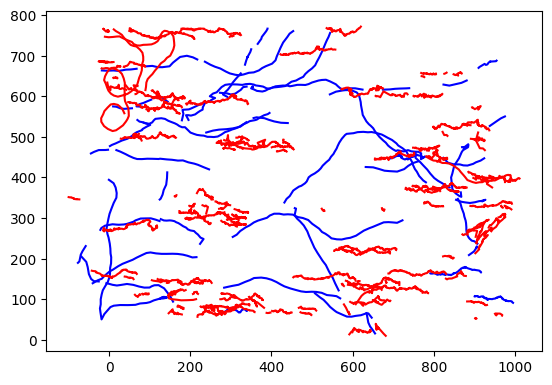

<Figure size 640x480 with 0 Axes>

In [36]:
# plot trajectories as living or dead (vertically inverted)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
for i in livinglist:
    plt.plot(orig_df[orig_df['particle']==i]['x'], orig_df[orig_df['particle']==i]['y'], '-b', label="living")
for i in deadlist:
    plt.plot(orig_df[orig_df['particle']==i]['x'], orig_df[orig_df['particle']==i]['y'], '-r', label="dead")
# plt.savefig("trajectories.pdf")
plt.show()
plt.clf()

# ~ END OF MAIN FILE CONTENT ~

## Other helpful operations

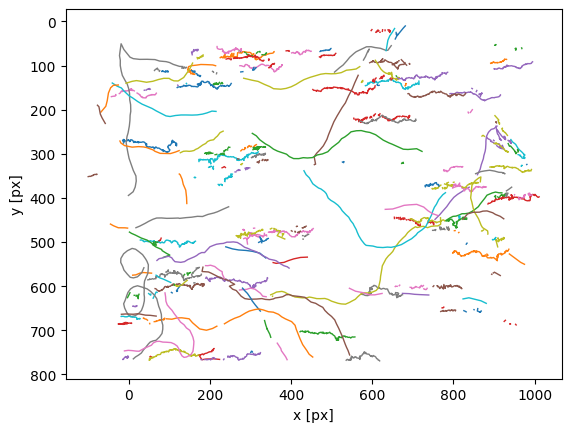

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [37]:
# plots the trajectories in original orientation
tp.plot_traj(orig_df, label=False)

/Users/viviantao/Documents/Johns Hopkins/research/MTB/count/.venv/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/Users/viviantao/Documents/Johns Hopkins/research/MTB/count/.venv/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]


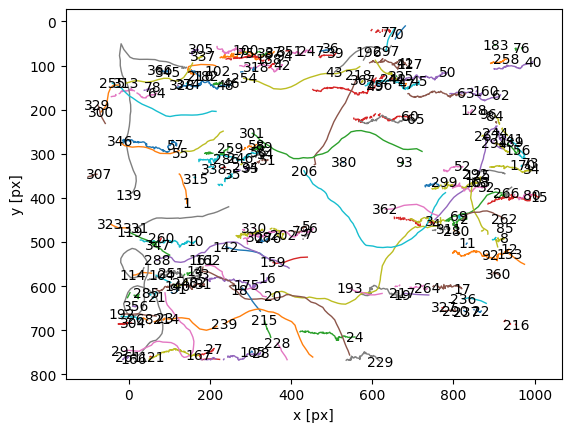

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [38]:
# plot trajectories with labels in original orientation
tp.plot_traj(orig_df, label=True)

(0.0, 800.0)

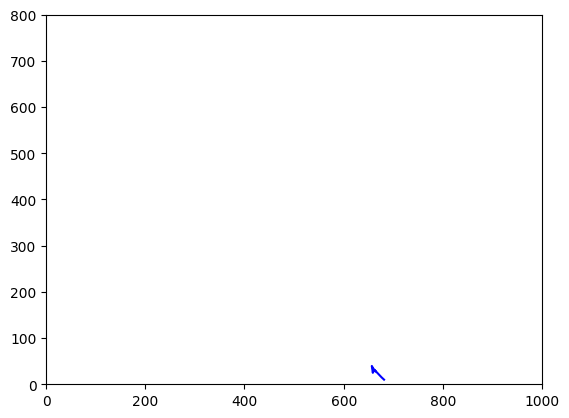

In [39]:
# plot a single trajectory of a living particle in original orientation with a specific particle number NUM
NUM = 0
plt.plot(orig_df[orig_df['particle']==NUM]['x'], orig_df[orig_df['particle']==NUM]['y'], '-b', label="living")
plt.xlim(0,1000)
plt.ylim(0,800)

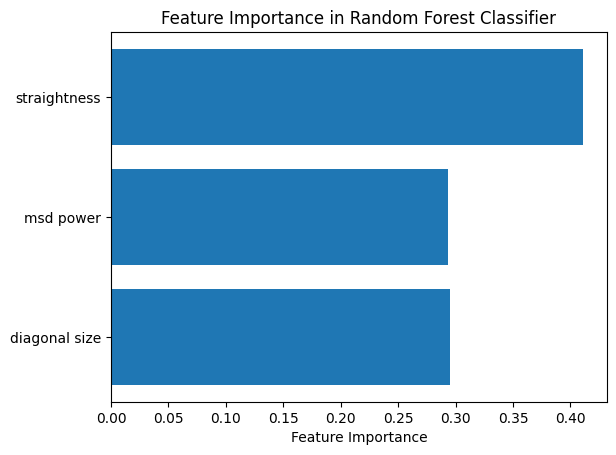

In [40]:
# shows the feature importances of the classifier model
feature_importances = model.feature_importances_

plt.barh(['diagonal size', 'msd power', 'straightness'], feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()